# Step 1: Import Libraries and Modules

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

importing libraries

In [12]:
import torch
import torchvision

torch.__version__, torchvision.__version__

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

Copying git repo to our working environment, its contains the module we wrote for managing data setup, etc.

In [13]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import modules made for code reuse
try:
    #from modules import data_setup, engine, utils
    from modules import data_setup, engine, metrics


except:
    # Get the scripts
    print("[INFO] Couldn't find modules scripts... downloading them from GitHub.")
    !git clone https://github.com/mlgomez0/melanoma-detection-model
    !mv melanoma-detection-model/modules .
    !rm -rf melanoma-detection-model
#    from modules import data_setup, engine, utils
    from modules import data_setup, engine, metrics



# Step 2: Download the Dataset

In [16]:
!pip install opendatasets --upgrade --quiet
clear_output()

Now we need to download the dataset from Kaggle and displays a sample image. Then ensure that we have the necessary data to train and evaluate our models. The dataset metadata is also loaded into a DataFrame for further processing

Skipping, found downloaded files in "./isic-2019-jpg-224x224-resized" (use force=True to force download)


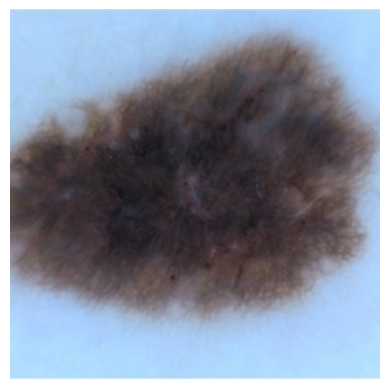

In [17]:
# To get the dataset it is required to create a Kaggle API token
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/nischaydnk/isic-2019-jpg-224x224-resized'
od.download(dataset_url)

df = pd.read_csv('isic-2019-jpg-224x224-resized/train-metadata.csv', index_col=0)

df.head() # dataset metadata

from PIL import Image
img = Image.open('isic-2019-jpg-224x224-resized/train-image/image/ISIC_0000000.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

# Step 3: Create Train and Test Folders

This step organizes the dataset by creating train and test directories and copying images into their respective folders based on their labels. This structure is necessary for using PyTorch's DataLoader to efficiently load and preprocess the data during training and evaluation

In [18]:
def create_train_test_folders(dataset_path, metadata_path, output_path):
    # Load metadata CSV
    df = pd.read_csv(metadata_path)

    # Split data into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'])

    # Create train and test directories
    train_dir = os.path.join(output_path, 'train')
    test_dir = os.path.join(output_path, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy images to train and test directories
    for index, row in train_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(train_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

    for index, row in test_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(test_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

dataset_path = 'isic-2019-jpg-224x224-resized/train-image/image'
metadata_path = 'isic-2019-jpg-224x224-resized/train-metadata.csv'
output_path = 'data'

create_train_test_folders(dataset_path, metadata_path, output_path)

train_dir = 'data/train'
test_dir = 'data/test'

# Step 4: Set Up Device

This step ensures that our code can run on either a GPU or CPU, depending on what is available. Try first with GPU because using a GPU can significantly speed up the training process for deep learning models

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # setting up device agnostic code

In [20]:
# Step 4.5: Create DataLoaders and get class names

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32
)

print(f"Classes: {class_names}")

Classes: ['0', '1']


# Step 5: Set Seed for Reproducibility

Setting a seed ensures reproducibility by fixing the random number generation. The create_writer function sets up TensorBoard logging, allowing us to visualize training metrics in real-time. This is useful for tracking the model's performance during training

In [21]:
def set_seed(seed:int=42):
    """Sets random seeds for torch operations.

    Args:
        seed (int, optional): The desired seed value. Defaults to 42.
    """
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

# Customizing the tensorboard logs
from datetime import datetime

def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None):
    timestamp = datetime.now().strftime("%y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)

# Step 6: Define and Train the Basic Perceptron Model

Here, we start first with a simple perceptron model, this step defines and trains a simple perceptron model. It includes a single linear layer with batch normalization. The model is trained using Adam optimizer and a learning rate scheduler. Training progress, including loss, accuracy, and recall for both training and testing sets, is tracked and printed for each epoch.

In [22]:
# Step 6: Define and Train the Basic Perceptron Model

class SimplePerceptron(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_features, output_features)
        self.bn = nn.BatchNorm1d(output_features)  # Add BatchNorm

    def forward(self, x):
        x = self.flatten(x)
        x = self.linearcomo(x)
        x = self.bn(x)  # Apply BatchNorm
        return x

model_0 = SimplePerceptron(224*224*3, len(class_names)).to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)  # Change to Adam optimizer

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Custom training loop
results_0 = {"train_loss": [], "train_acc": [], "train_recall": [], "test_loss": [], "test_acc": [], "test_recall": []}

for epoch in range(10):
    train_loss, train_acc = engine.train_step(model_0, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = engine.test_step(model_0, test_dataloader, loss_fn, device)

    # Calculate recall for both train and test sets
    train_recall = metrics.calculate_recall(model_0, train_dataloader, device)
    test_recall = metrics.calculate_recall(model_0, test_dataloader, device)

    results_0["train_loss"].append(train_loss)
    results_0["train_acc"].append(train_acc)
    results_0["train_recall"].append(train_recall)
    results_0["test_loss"].append(test_loss)
    results_0["test_acc"].append(test_acc)
    results_0["test_recall"].append(test_recall)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_recall: {train_recall:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | test_recall: {test_recall:.4f}")

    # Step the scheduler
    scheduler.step(test_loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.5428 | train_acc: 0.7677 | train_recall: 0.8226 | test_loss: 0.4599 | test_acc: 0.8201 | test_recall: 0.8223


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | train_loss: 0.4462 | train_acc: 0.8217 | train_recall: 0.8233 | test_loss: 0.4378 | test_acc: 0.8206 | test_recall: 0.8228


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | train_loss: 0.4365 | train_acc: 0.8214 | train_recall: 0.8266 | test_loss: 0.4361 | test_acc: 0.8233 | test_recall: 0.8255


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | train_loss: 0.4343 | train_acc: 0.8228 | train_recall: 0.8239 | test_loss: 0.4329 | test_acc: 0.8210 | test_recall: 0.8231


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | train_loss: 0.4329 | train_acc: 0.8233 | train_recall: 0.8241 | test_loss: 0.4396 | test_acc: 0.8204 | test_recall: 0.8226


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | train_loss: 0.4315 | train_acc: 0.8243 | train_recall: 0.8264 | test_loss: 0.4350 | test_acc: 0.8243 | test_recall: 0.8265


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | train_loss: 0.4313 | train_acc: 0.8248 | train_recall: 0.8259 | test_loss: 0.4310 | test_acc: 0.8238 | test_recall: 0.8260


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | train_loss: 0.4301 | train_acc: 0.8245 | train_recall: 0.8292 | test_loss: 0.4283 | test_acc: 0.8267 | test_recall: 0.8289


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | train_loss: 0.4283 | train_acc: 0.8248 | train_recall: 0.8284 | test_loss: 0.4263 | test_acc: 0.8254 | test_recall: 0.8276


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | train_loss: 0.4308 | train_acc: 0.8248 | train_recall: 0.8267 | test_loss: 0.4251 | test_acc: 0.8243 | test_recall: 0.8265


# Step 7: Define and Train the MLP Model


In [23]:
class MLP(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.BatchNorm1d(hidden_units),  # Add BatchNorm
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),  # Add BatchNorm
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layer_stack(x)

model_1 = MLP(224*224*3, 64, len(class_names)).to(device)

# Train the MLP model
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)  # Change to Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Custom training loop
results_1 = {"train_loss": [], "train_acc": [], "train_recall": [], "test_loss": [], "test_acc": [], "test_recall": []}

for epoch in range(10):
    train_loss, train_acc = engine.train_step(model_1, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = engine.test_step(model_1, test_dataloader, loss_fn, device)

    # Calculate recall for both train and test sets
    train_recall = metrics.calculate_recall(model_1, train_dataloader, device)
    test_recall = metrics.calculate_recall(model_1, test_dataloader, device)

    results_1["train_loss"].append(train_loss)
    results_1["train_acc"].append(train_acc)
    results_1["train_recall"].append(train_recall)
    results_1["test_loss"].append(test_loss)
    results_1["test_acc"].append(test_acc)
    results_1["test_recall"].append(test_recall)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | train_recall: {train_recall:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | test_recall: {test_recall:.4f}")

    # Step the scheduler
    scheduler.step(test_loss)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.4267 | train_acc: 0.8235 | train_recall: 0.8254 | test_loss: 0.4256 | test_acc: 0.8235 | test_recall: 0.8254


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | train_loss: 0.4045 | train_acc: 0.8322 | train_recall: 0.8367 | test_loss: 0.3958 | test_acc: 0.8354 | test_recall: 0.8366


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | train_loss: 0.3953 | train_acc: 0.8363 | train_recall: 0.8409 | test_loss: 0.3909 | test_acc: 0.8384 | test_recall: 0.8396


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | train_loss: 0.3885 | train_acc: 0.8381 | train_recall: 0.8444 | test_loss: 0.3966 | test_acc: 0.8441 | test_recall: 0.8457


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | train_loss: 0.3848 | train_acc: 0.8399 | train_recall: 0.8369 | test_loss: 0.3937 | test_acc: 0.8353 | test_recall: 0.8368


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | train_loss: 0.3773 | train_acc: 0.8442 | train_recall: 0.8479 | test_loss: 0.3656 | test_acc: 0.8482 | test_recall: 0.8501


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | train_loss: 0.3753 | train_acc: 0.8443 | train_recall: 0.7351 | test_loss: 0.5009 | test_acc: 0.7416 | test_recall: 0.7423


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | train_loss: 0.3698 | train_acc: 0.8470 | train_recall: 0.8540 | test_loss: 0.3544 | test_acc: 0.8523 | test_recall: 0.8539


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | train_loss: 0.3636 | train_acc: 0.8479 | train_recall: 0.8535 | test_loss: 0.3610 | test_acc: 0.8518 | test_recall: 0.8537


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | train_loss: 0.3618 | train_acc: 0.8494 | train_recall: 0.8321 | test_loss: 0.3909 | test_acc: 0.8279 | test_recall: 0.8291


# Step 8: Save the Trained Models

After training both the Simple Perceptron and MLP models

In [24]:
import os

# Create a directory for saving models if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the Simple Perceptron model
torch.save(model_0.state_dict(), "models/simple_perceptron.pth")
print("Simple Perceptron model saved.")

# Save the MLP model
torch.save(model_1.state_dict(), "models/mlp_model.pth")
print("MLP model saved.")

Simple Perceptron model saved.
MLP model saved.


# Step 9: Visualize and Compare Results

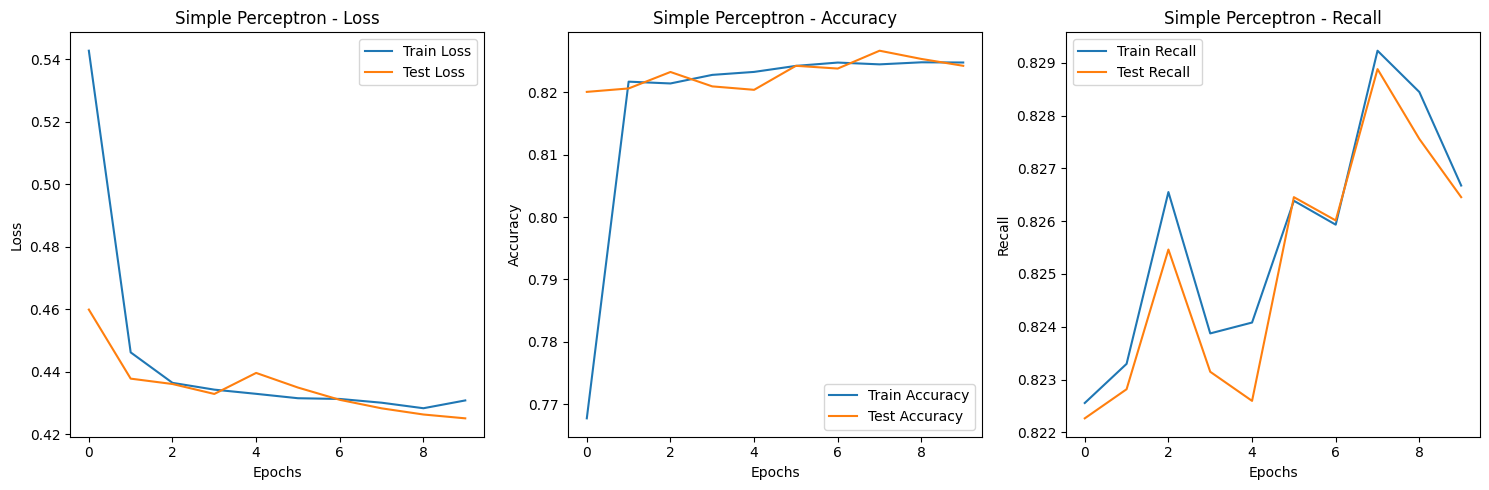

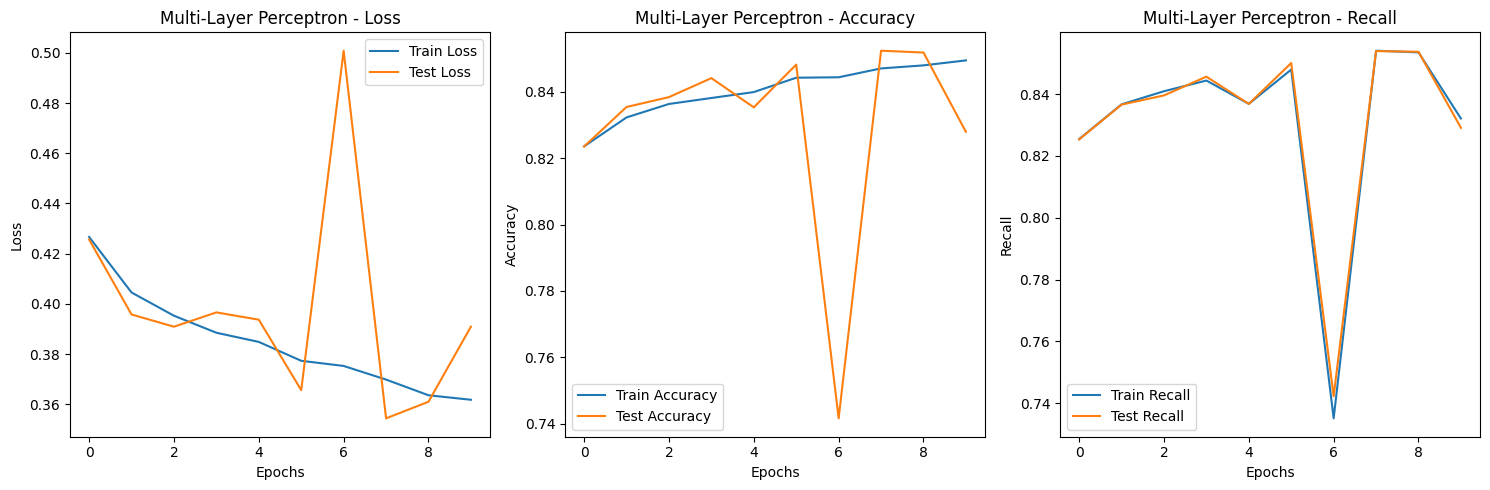

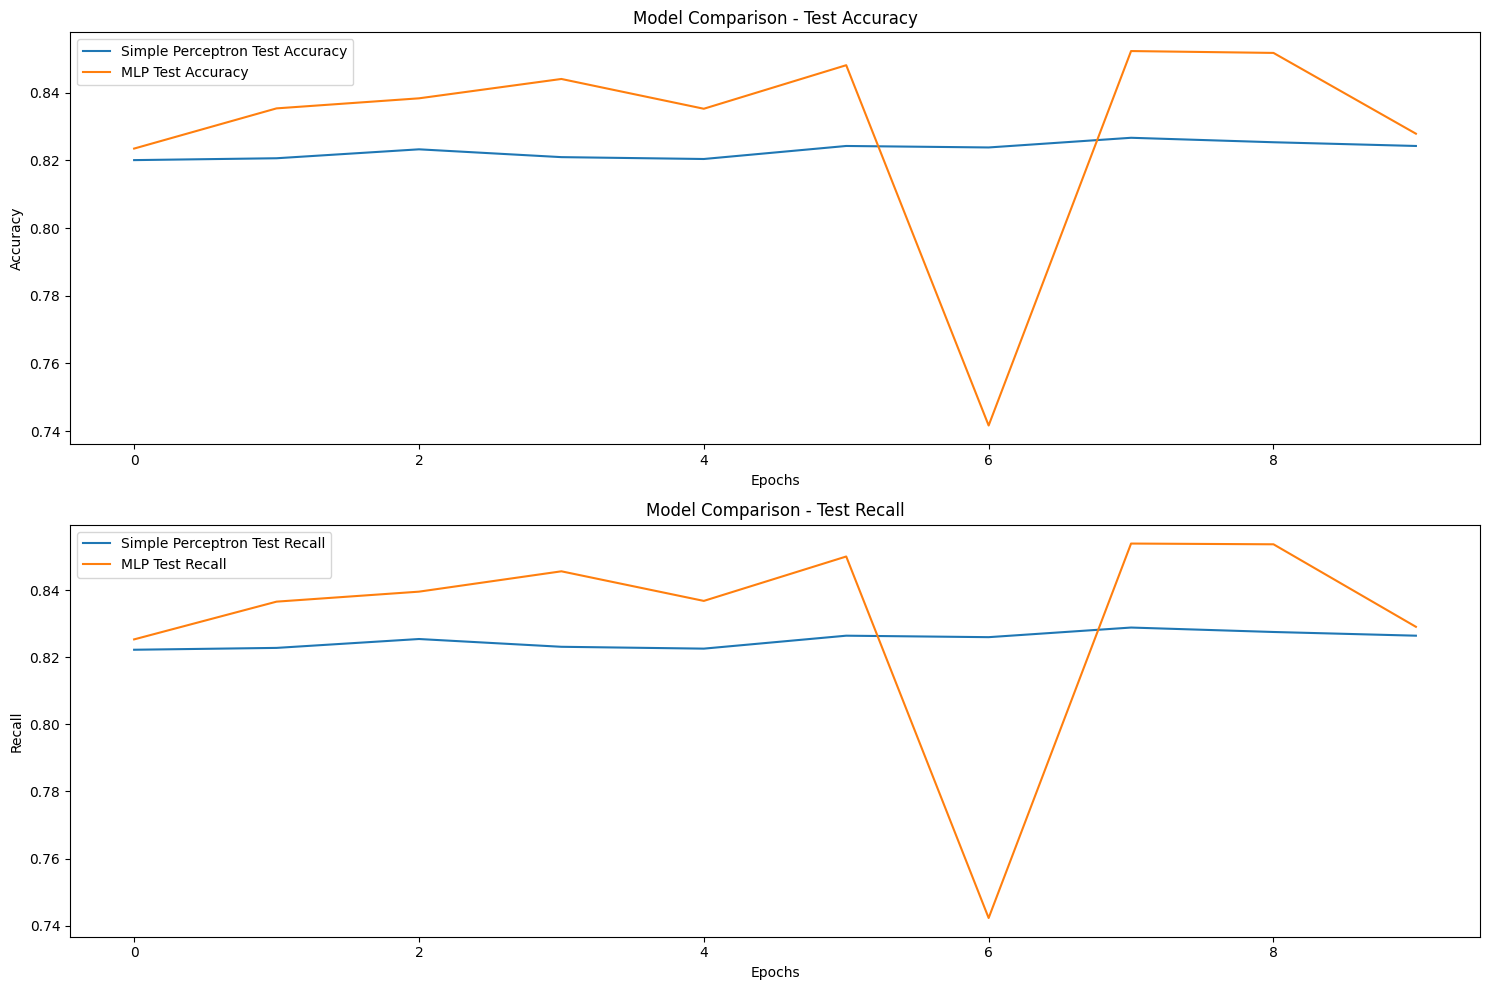

In [25]:
def plot_results(results, model_name):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(results['train_acc'], label='Train Accuracy')
    plt.plot(results['test_acc'], label='Test Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['train_recall'], label='Train Recall')
    plt.plot(results['test_recall'], label='Test Recall')
    plt.title(f'{model_name} - Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for both models
plot_results(results_0, 'Simple Perceptron')
plot_results(results_1, 'Multi-Layer Perceptron')

# Compare models
def compare_models(results_list, model_names):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    for results, name in zip(results_list, model_names):
        plt.plot(results['test_acc'], label=f'{name} Test Accuracy')
    plt.title('Model Comparison - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    for results, name in zip(results_list, model_names):
        plt.plot(results['test_recall'], label=f'{name} Test Recall')
    plt.title('Model Comparison - Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_models([results_0, results_1], ['Simple Perceptron', 'MLP'])

# Step 10: Load and Test Saved Models

To ensure our saved models work correctly, let's load them and perform a quick test:

In [27]:
def load_model(model_class, model_path, input_features, hidden_units, output_features):
    model = model_class(input_features, hidden_units, output_features).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load Simple Perceptron
loaded_model_0 = SimplePerceptron(224*224*3, len(class_names)).to(device)
loaded_model_0.load_state_dict(torch.load("models/simple_perceptron.pth"))
loaded_model_0.eval()

# Load MLP
loaded_model_1 = load_model(MLP, "models/mlp_model.pth", 224*224*3, 64, len(class_names))

# Test the loaded models
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f"Loaded Simple Perceptron Accuracy: {test_model(loaded_model_0, test_dataloader):.2f}%")
print(f"Loaded MLP Accuracy: {test_model(loaded_model_1, test_dataloader):.2f}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loaded Simple Perceptron Accuracy: 82.65%
Loaded MLP Accuracy: 82.91%


Step 11: Visualize the Perceptron


In [28]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=ee449b1b09a10032e7079ba5136c54140f539dd606e3b20636925687265aace8
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [29]:
from torchviz import make_dot

# Visualize Simple Perceptron
x = torch.randn(1, 3, 224, 224).to(device)  # Example input
y = model_0(x)
dot = make_dot(y, params=dict(model_0.named_parameters()))
dot.render("simple_perceptron_architecture", format="png")

'simple_perceptron_architecture.png'